In [1]:
!pip install datasets
from datasets import load_dataset, load_metric

!pip install transformers==4.28.0
from transformers import AutoTokenizer, DefaultDataCollator, AutoModelForQuestionAnswering, TrainingArguments, Trainer, create_optimizer, pipeline

import json
import pandas as pd
import datasets
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
DATASETS = {"pquad": 0}

class DatasetLoader:
    def __init__(self, dataset, tokenizer):
        self.tokenizer = tokenizer
        self.dataset = datasets.DatasetDict()
        dataset_to_loader = {
            DATASETS["pquad"]: self.__load_dataset,
        }
        self.dataset = dataset_to_loader[dataset]()
        self.tokenized_dataset = self.dataset.map(self.preprocess_function, batched=True, remove_columns=self.dataset["train"].column_names)

    def __extract_entries(self, data, limit=200000000):
        df_list = []
        c = 0
        length_distribution = []
        for d in tqdm(data['data'], desc="Converting json to dataset"):
            for p in d['paragraphs']:
                length_distribution.append(len(p['context'].split()))
                for qas in p['qas']:
                    c += 1
                    if c > limit:
                        return df_list
                    if qas["is_impossible"]:
                        continue
                        df_list.append({
                            "id": str(qas['id']),
                            "title": d['title'],
                            "context": p['context'],
                            "question": qas['question'],
                            "answers": {"text": "", "answer_start": 0}
                        })
                    else:
                        for answer in qas['answers']:
                            df_list.append({
                                "id": str(qas['id']),
                                "title": d['title'],
                                "context": p['context'],
                                "question": qas['question'],
                                "answers": {"text": answer["text"], "answer_start": answer["answer_start"]}
                            })
        plt.hist(length_distribution)
        plt.title("Length Distribution")
        plt.show()
        return df_list

    def __load_dataset(self):
        self.dataset = datasets.DatasetDict()
        for part in ["train", "validation", "test"]:
            with open(f"data/{part}_samples.json", 'r', encoding='utf-8') as f:
                data = json.load(f)
            df_list = self.__extract_entries(data)
            self.dataset[part] = datasets.Dataset.from_pandas(pd.DataFrame.from_dict(df_list))
        return self.dataset

    def preprocess_function(self, examples):
        questions = [q.strip() for q in examples["question"]]
        inputs = self.tokenizer(
            questions,
            examples["context"],
            max_length=380,
            truncation="only_second",
            return_offsets_mapping=True,
        )

        offset_mapping = inputs.pop("offset_mapping")
        answers = examples["answers"]
        start_positions = []
        end_positions = []

        for i, offset in enumerate(offset_mapping):  # offset is [(start_char, end_char), ...]
            answer = answers[i]
            start_char = answer["answer_start"]
            end_char = answer["answer_start"] + len(answer["text"])
            sequence_ids = inputs.sequence_ids(i)

            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is not fully inside the context, label it (0, 0)
            if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
                # Otherwise it's the start and end token positions
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)

        inputs["start_positions"] = start_positions
        inputs["end_positions"] = end_positions
        return inputs

In [3]:
class TrainerQA:
    def __init__(self, model_checkpoint, dataset):
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        self.dataset_loader = DatasetLoader(dataset, self.tokenizer)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

    def train(self, num_train_epochs=3, learning_rate=2e-5):
        data_collator = DefaultDataCollator()
        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=num_train_epochs,
            weight_decay=0.01,
            group_by_length=True,
            logging_steps=20
        )
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.dataset_loader.tokenized_dataset["train"],
            eval_dataset=self.dataset_loader.tokenized_dataset["validation"],
            tokenizer=self.tokenizer,
        )
        self.trainer.train()

    def evaluate(self):
        qa_model = pipeline("question-answering", model=self.model, tokenizer=self.tokenizer, device=0)
        questions = self.dataset_loader.dataset["test"]["question"]
        contexts = self.dataset_loader.dataset["test"]["context"]
        preds = qa_model(question = questions, context = contexts, device="cuda")

        metric = load_metric("squad")
        last_id = -1
        predictions, references = [], []
        for i, answers in tqdm(enumerate(self.dataset_loader.dataset["test"]["answers"])):
            if len(answers["text"]) < 1:
                continue
            id = self.dataset_loader.dataset["test"][i]["id"]
            if id != last_id:
                predictions.append({
                    "id": id,
                    "prediction_text": preds[i]["answer"].strip()
                })
                references.append({
                    "id": id,
                    "answers": []
                })
                last_id = id
            references[-1]["answers"].append(answers)
        results = metric.compute(predictions=predictions, references=references)
        print(results)
        return results

## Traning using BERT

Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

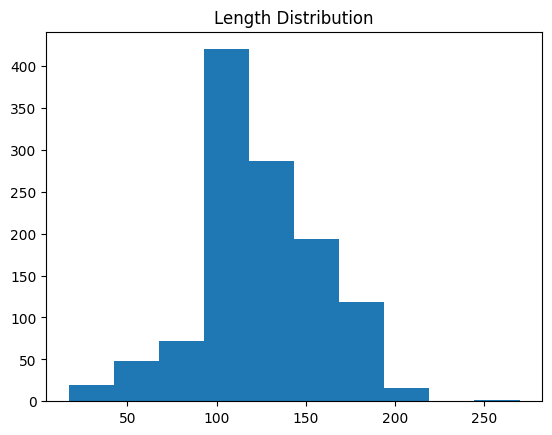

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

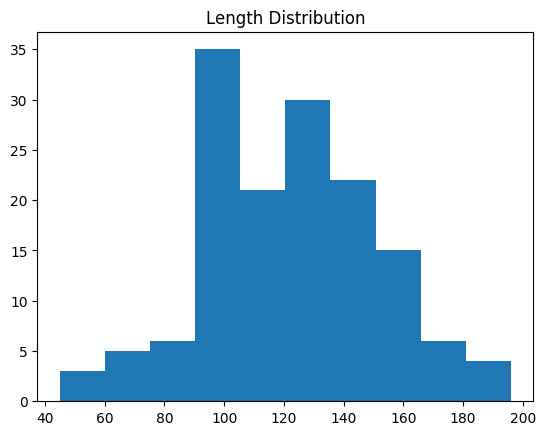

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

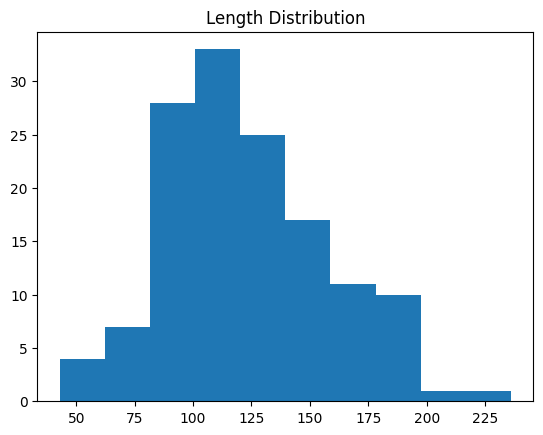

Map:   0%|          | 0/5917 [00:00<?, ? examples/s]

Map:   0%|          | 0/1184 [00:00<?, ? examples/s]

Map:   0%|          | 0/1048 [00:00<?, ? examples/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

Epoch,Training Loss,Validation Loss
1,1.421200,1.542079
2,0.728200,1.560962
3,0.596300,1.663904


<ipython-input-3-76d82fcf2512>:35: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad")


0it [00:00, ?it/s]

{'exact_match': 57.298772169167805, 'f1': 78.76097226211233}


{'exact_match': 57.298772169167805, 'f1': 78.76097226211233}

In [4]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
dataset = DATASETS["pquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()

## Training using ALBERT

Converting json to dataset:   0%|          | 0/120 [00:00<?, ?it/s]

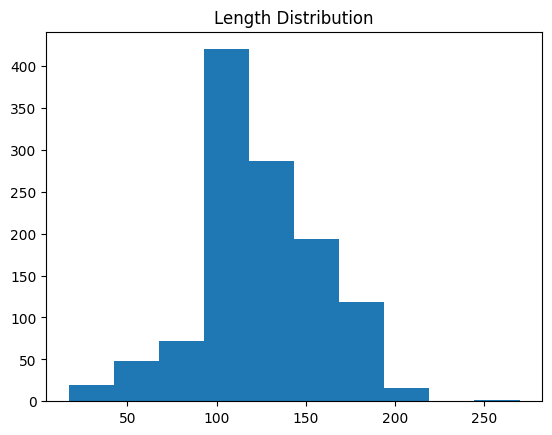

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

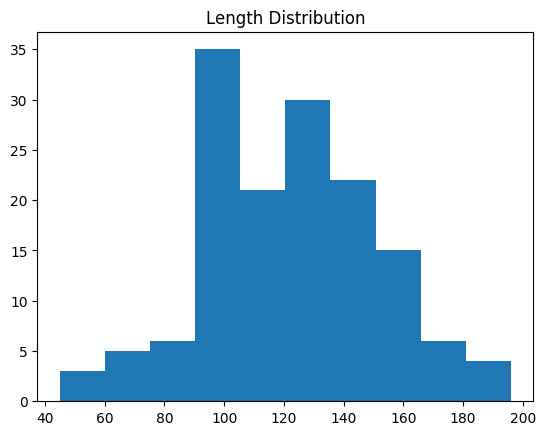

Converting json to dataset:   0%|          | 0/15 [00:00<?, ?it/s]

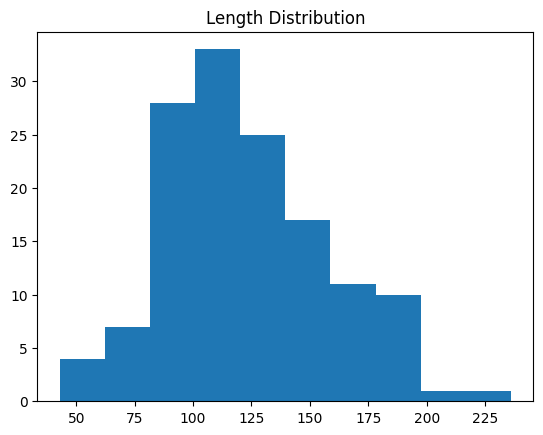

Map:   0%|          | 0/5917 [00:00<?, ? examples/s]

Map:   0%|          | 0/1184 [00:00<?, ? examples/s]

Map:   0%|          | 0/1048 [00:00<?, ? examples/s]

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['sop_classifier.classifier.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

Epoch,Training Loss,Validation Loss
1,1.321500,1.576812
2,0.765900,1.566305
3,0.623100,1.667838


0it [00:00, ?it/s]

{'exact_match': 48.70395634379263, 'f1': 72.87481869473929}


{'exact_match': 48.70395634379263, 'f1': 72.87481869473929}

In [5]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
dataset = DATASETS["pquad"]
trainer = TrainerQA(model_checkpoint, dataset)
trainer.train()
trainer.evaluate()